In [1]:
import pandas as pd
import sklearn 
import scipy
from sklearn import linear_model as lm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_validation import KFold, train_test_split, cross_val_score, StratifiedKFold, LabelKFold, ShuffleSplit
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from mhcflurry.amino_acid import common_amino_acids
from mhcflurry import dataset
from mhcflurry.dataset import Dataset
import matplotlib.pyplot as plt 
% matplotlib inline
import numpy as np
import math 
from mhcflurry import peptide_encoding, amino_acid
import statsmodels.api as sm
from keras import models, layers, optimizers
from keras.optimizers import Adam, SGD
from keras.models import Sequential
from keras.utils.layer_utils import layer_from_config
from keras.layers import Dense, Dropout, TimeDistributed, Embedding, LSTM, Input, merge, Convolution1D, AveragePooling1D, Activation, Flatten
from keras.preprocessing import sequence
from keras.models import Model
from keras.engine import topology
import seaborn as sns
from math import exp

Using Theano backend.


In [2]:
df = pd.read_table("bdata.2009.mhci.public.1.txt")

df['log_meas']=1-np.log(df['meas'])/math.log(50000)
df['peptide_length'] = df['sequence'].str.len()


max_len=df['sequence'].str.len().max()
n_peptides = df['sequence'].count()

def amino_acid_hotshot_encoding(s):
    return common_amino_acids.hotshot_encoding([s],len(s)).flatten().astype(int)
df['hotshot_encoded_peptides'] = df.sequence.apply(lambda seq: amino_acid_hotshot_encoding(seq))

def amino_acid_index_encoding(s, maxlen):
    a = 1+common_amino_acids.index_encoding([s],len(s)).flatten()
    return np.concatenate([a, np.zeros(maxlen-len(a),dtype=int)])
df['index_encoded_peptides'] = df.sequence.apply(lambda seq: amino_acid_index_encoding(seq, max_len))

def measured_affinity_less_than(Y,k):
    IC50 = 50000**(1-Y)
    return (IC50 < k).astype(int) 

def affinity_label(Y):
    return measured_affinity_less_than(Y,50) + measured_affinity_less_than(Y,500) + measured_affinity_less_than(Y,5000) + measured_affinity_less_than(Y,50000)

df['affinity_label'] = affinity_label(df['log_meas'])
df_h = df[df['mhc']=='HLA-A-0201'][['hotshot_encoded_peptides','index_encoded_peptides','log_meas','peptide_length']]
X = np.array(list(df_h['index_encoded_peptides']))
y = np.array(list(df_h['log_meas']))
y[y<0]=0

In [ ]:
folds = 3
batch_size_nn = 16
batch_size_lstm = 16
hidden = 50
dropout_probability = 0.25

n_epochs = 50
epoch = 0

train_lstm_lr_1_0_aucs = np.zeros((folds,n_epochs))
test_lstm_lr_1_0_aucs = np.zeros((folds,n_epochs))

train_lstm_lr_1_1_aucs = np.zeros((folds,n_epochs))
test_lstm_lr_1_1_aucs = np.zeros((folds,n_epochs))

train_lstm_lr_1_2_aucs = np.zeros((folds,n_epochs))
test_lstm_lr_1_2_aucs = np.zeros((folds,n_epochs))

train_lstm_lr_1_3_aucs = np.zeros((folds,n_epochs))
test_lstm_lr_1_3_aucs = np.zeros((folds,n_epochs))

train_lstm_lr_1_4_aucs = np.zeros((folds,n_epochs))
test_lstm_lr_1_4_aucs = np.zeros((folds,n_epochs))

#-----------------------

train_lstm_lr_10_0_aucs = np.zeros((folds,n_epochs))
test_lstm_lr_10_0_aucs = np.zeros((folds,n_epochs))

train_lstm_lr_10_1_aucs = np.zeros((folds,n_epochs))
test_lstm_lr_10_1_aucs = np.zeros((folds,n_epochs))

train_lstm_lr_10_2_aucs = np.zeros((folds,n_epochs))
test_lstm_lr_10_2_aucs = np.zeros((folds,n_epochs))

train_lstm_lr_10_3_aucs = np.zeros((folds,n_epochs))
test_lstm_lr_10_3_aucs = np.zeros((folds,n_epochs))

train_lstm_lr_10_4_aucs = np.zeros((folds,n_epochs))
test_lstm_lr_10_4_aucs = np.zeros((folds,n_epochs))

#---------------------------

train_lstm_lr_100_0_aucs = np.zeros((folds,n_epochs))
test_lstm_lr_100_0_aucs = np.zeros((folds,n_epochs))

train_lstm_lr_100_1_aucs = np.zeros((folds,n_epochs))
test_lstm_lr_100_1_aucs = np.zeros((folds,n_epochs))

train_lstm_lr_100_2_aucs = np.zeros((folds,n_epochs))
test_lstm_lr_100_2_aucs = np.zeros((folds,n_epochs))

train_lstm_lr_100_3_aucs = np.zeros((folds,n_epochs))
test_lstm_lr_100_3_aucs = np.zeros((folds,n_epochs))

train_lstm_lr_100_4_aucs = np.zeros((folds,n_epochs))
test_lstm_lr_100_4_aucs = np.zeros((folds,n_epochs))

#-----------------------------------------

train_lstm_lr_1000_0_aucs = np.zeros((folds,n_epochs))
test_lstm_lr_1000_0_aucs = np.zeros((folds,n_epochs))

train_lstm_lr_1000_1_aucs = np.zeros((folds,n_epochs))
test_lstm_lr_1000_1_aucs = np.zeros((folds,n_epochs))

train_lstm_lr_1000_2_aucs = np.zeros((folds,n_epochs))
test_lstm_lr_1000_2_aucs = np.zeros((folds,n_epochs))

train_lstm_lr_1000_3_aucs = np.zeros((folds,n_epochs))
test_lstm_lr_1000_3_aucs = np.zeros((folds,n_epochs))

train_lstm_lr_1000_4_aucs = np.zeros((folds,n_epochs))
test_lstm_lr_1000_4_aucs = np.zeros((folds,n_epochs))

for i, (train_idx, test_idx) in enumerate(KFold(len(df_h),folds, shuffle=True)):
 
    
    
    
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm_lr_1_0 = Model(input = sequence, output = output)
    adam_lr_1_0 = Adam(lr = 0.05)
    lstm_lr_1_0.compile(optimizer = adam_lr_1_0 , loss='mean_squared_error')
    
    
    
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm_lr_1_1 = Model(input = sequence, output = output)
    adam_lr_1_1 = Adam(lr = 0.05)
    lstm_lr_1_1.compile(optimizer = adam_lr_1_1 , loss='mean_squared_error')
    
    
    
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm_lr_1_2 = Model(input = sequence, output = output)
    adam_lr_1_2 = Adam(lr = 0.05)
    lstm_lr_1_2.compile(optimizer = adam_lr_1_2 , loss='mean_squared_error')
    
    
    
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm_lr_1_3 = Model(input = sequence, output = output)
    adam_lr_1_3 = Adam(lr = 0.05)
    lstm_lr_1_3.compile(optimizer = adam_lr_1_3 , loss='mean_squared_error')
    
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm_lr_1_4 = Model(input = sequence, output = output)
    adam_lr_1_4 = Adam(lr = 0.05)
    lstm_lr_1_4.compile(optimizer = adam_lr_1_4 , loss='mean_squared_error')
    
    
    #-------------------------------------------------------------------------
    
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm_lr_10_0 = Model(input = sequence, output = output)
    adam_lr_10_0 = Adam(lr = 0.01)
    lstm_lr_10_0.compile(optimizer = adam_lr_10_0 , loss='mean_squared_error')
    
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm_lr_10_1 = Model(input = sequence, output = output)
    adam_lr_10_1 = Adam(lr = 0.01)
    lstm_lr_10_1.compile(optimizer = adam_lr_10_1 , loss='mean_squared_error')
    
    
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm_lr_10_2 = Model(input = sequence, output = output)
    adam_lr_10_2 = Adam(lr = 0.01)
    lstm_lr_10_2.compile(optimizer = adam_lr_10_2 , loss='mean_squared_error')
    
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm_lr_10_3 = Model(input = sequence, output = output)
    adam_lr_10_3 = Adam(lr = 0.01)
    lstm_lr_10_3.compile(optimizer = adam_lr_10_3 , loss='mean_squared_error')
    
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm_lr_10_4 = Model(input = sequence, output = output)
    adam_lr_10_4 = Adam(lr = 0.01)
    lstm_lr_10_4.compile(optimizer = adam_lr_10_4 , loss='mean_squared_error')
    
    
    #---------------------------------------------------------------------------------

    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm_lr_100_0 = Model(input = sequence, output = output)
    adam_lr_100_0 = Adam(lr = 0.005)
    lstm_lr_100_0.compile(optimizer = adam_lr_100_0 , loss='mean_squared_error')
    
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm_lr_100_1 = Model(input = sequence, output = output)
    adam_lr_100_1 = Adam(lr = 0.005)
    lstm_lr_100_1.compile(optimizer = adam_lr_100_1 , loss='mean_squared_error')
    
    
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm_lr_100_2 = Model(input = sequence, output = output)
    adam_lr_100_2 = Adam(lr = 0.005)
    lstm_lr_100_2.compile(optimizer = adam_lr_100_2 , loss='mean_squared_error')
    
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm_lr_100_3 = Model(input = sequence, output = output)
    adam_lr_100_3 = Adam(lr = 0.005)
    lstm_lr_100_3.compile(optimizer = adam_lr_100_3 , loss='mean_squared_error')
    
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm_lr_100_4 = Model(input = sequence, output = output)
    adam_lr_100_4 = Adam(lr = 0.005)
    lstm_lr_100_4.compile(optimizer = adam_lr_100_4 , loss='mean_squared_error')
    
    
    #------------------------------------------------------------------------------
    
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm_lr_1000_0 = Model(input = sequence, output = output)
    adam_lr_1000_0 = Adam(lr = 0.001)
    lstm_lr_1000_0.compile(optimizer = adam_lr_1000_0 , loss='mean_squared_error')
    
    
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm_lr_1000_1 = Model(input = sequence, output = output)
    adam_lr_1000_1 = Adam(lr = 0.001)
    lstm_lr_1000_1.compile(optimizer = adam_lr_1000_1 , loss='mean_squared_error')
    
    
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm_lr_1000_2 = Model(input = sequence, output = output)
    adam_lr_1000_2 = Adam(lr = 0.001)
    lstm_lr_1000_2.compile(optimizer = adam_lr_1000_2 , loss='mean_squared_error')
    
    
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm_lr_1000_3 = Model(input = sequence, output = output)
    adam_lr_1000_3 = Adam(lr = 0.001)
    lstm_lr_1000_3.compile(optimizer = adam_lr_1000_3 , loss='mean_squared_error')
    
    
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm_lr_1000_4 = Model(input = sequence, output = output)
    adam_lr_1000_4 = Adam(lr = 0.001)
    lstm_lr_1000_4.compile(optimizer = adam_lr_1000_4 , loss='mean_squared_error')

    
    
    for epoch in range(n_epochs):
        
        

        adam_lr_1_0.lr.set_value(0.05)
        lstm_lr_1_0.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    

        train_lstm_lr_1_0_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm_lr_1_0.predict(X[train_idx]))
        test_lstm_lr_1_0_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm_lr_1_0.predict(X[test_idx]))
        
        train_lstm_lr_1_0_aucs[i][epoch]=train_lstm_lr_1_0_auc
        test_lstm_lr_1_0_aucs[i][epoch]=test_lstm_lr_1_0_auc
        print("LSTM LR = 0.1*t^0 ", train_lstm_lr_1_0_auc, test_lstm_lr_1_0_auc, epoch)
        print("current learning rate: ", adam_lr_1_0.lr.get_value() )
        
        
        adam_lr_1_1.lr.set_value(0.05*(epoch+1)**(-1))
        lstm_lr_1_1.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    

        train_lstm_lr_1_1_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm_lr_1_1.predict(X[train_idx]))
        test_lstm_lr_1_1_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm_lr_1_1.predict(X[test_idx]))
        
        train_lstm_lr_1_1_aucs[i][epoch]=train_lstm_lr_1_1_auc
        test_lstm_lr_1_1_aucs[i][epoch]=test_lstm_lr_1_1_auc
        print("LSTM LR = 0.05*t^(-1) ", train_lstm_lr_1_1_auc, test_lstm_lr_1_1_auc, epoch)
        print("current learning rate: ", adam_lr_1_1.lr.get_value() )
        
        
        
        adam_lr_1_2.lr.set_value(0.05*(epoch+1)**(-2))
        lstm_lr_1_2.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    

        train_lstm_lr_1_2_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm_lr_1_2.predict(X[train_idx]))
        test_lstm_lr_1_2_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm_lr_1_2.predict(X[test_idx]))
        
        train_lstm_lr_1_2_aucs[i][epoch]=train_lstm_lr_1_2_auc
        test_lstm_lr_1_2_aucs[i][epoch]=test_lstm_lr_1_2_auc
        print("LSTM LR = 0.05*t^(-2) ", train_lstm_lr_1_2_auc, test_lstm_lr_1_2_auc, epoch)
        print("current learning rate: ", adam_lr_1_2.lr.get_value() )
        
        
        adam_lr_1_3.lr.set_value(0.05*(epoch+1)**(-3))
        lstm_lr_1_3.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    

        train_lstm_lr_1_3_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm_lr_1_3.predict(X[train_idx]))
        test_lstm_lr_1_3_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm_lr_1_3.predict(X[test_idx]))
        
        train_lstm_lr_1_3_aucs[i][epoch]=train_lstm_lr_1_3_auc
        test_lstm_lr_1_3_aucs[i][epoch]=test_lstm_lr_1_3_auc
        print("LSTM LR = 0.05*t^(-3) ", train_lstm_lr_1_3_auc, test_lstm_lr_1_3_auc, epoch)
        print("current learning rate: ", adam_lr_1_3.lr.get_value() )
        
        
        
        adam_lr_1_4.lr.set_value(0.05*(epoch+1)**(-4))
        lstm_lr_1_4.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    

        train_lstm_lr_1_4_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm_lr_1_4.predict(X[train_idx]))
        test_lstm_lr_1_4_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm_lr_1_4.predict(X[test_idx]))
        
        train_lstm_lr_1_4_aucs[i][epoch]=train_lstm_lr_1_4_auc
        test_lstm_lr_1_4_aucs[i][epoch]=test_lstm_lr_1_4_auc
        print("LSTM LR = 0.05*t^(-4) ", train_lstm_lr_1_4_auc, test_lstm_lr_1_4_auc, epoch)
        print("current learning rate: ", adam_lr_1_4.lr.get_value() )
        

    
        #----------------------------------------

        
        
    
        adam_lr_10_0.lr.set_value(0.01)
        lstm_lr_10_0.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    

        train_lstm_lr_10_0_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm_lr_10_0.predict(X[train_idx]))
        test_lstm_lr_10_0_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm_lr_10_0.predict(X[test_idx]))
        
        train_lstm_lr_10_0_aucs[i][epoch]=train_lstm_lr_10_0_auc
        test_lstm_lr_10_0_aucs[i][epoch]=test_lstm_lr_10_0_auc
        print("LSTM LR = 0.01): ", train_lstm_lr_10_0_auc, test_lstm_lr_10_0_auc, epoch)
        print("current learning rate: ", adam_lr_10_0.lr.get_value() )   
        
        
        
        adam_lr_10_1.lr.set_value(0.01*(epoch+1)**(-1))
        lstm_lr_10_1.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    

        train_lstm_lr_10_1_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm_lr_10_1.predict(X[train_idx]))
        test_lstm_lr_10_1_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm_lr_10_1.predict(X[test_idx]))
        
        train_lstm_lr_10_1_aucs[i][epoch]=train_lstm_lr_10_1_auc
        test_lstm_lr_10_1_aucs[i][epoch]=test_lstm_lr_10_1_auc
        print("LSTM LR = 0.01*t^(-1): ", train_lstm_lr_10_1_auc, test_lstm_lr_10_1_auc, epoch)
        print("current learning rate: ", adam_lr_10_1.lr.get_value() )
        
        
        
        adam_lr_10_2.lr.set_value(0.01*(epoch+1)**(-2))
        lstm_lr_10_2.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    

        train_lstm_lr_10_2_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm_lr_10_2.predict(X[train_idx]))
        test_lstm_lr_10_2_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm_lr_10_2.predict(X[test_idx]))
        
        train_lstm_lr_10_2_aucs[i][epoch]=train_lstm_lr_10_2_auc
        test_lstm_lr_10_2_aucs[i][epoch]=test_lstm_lr_10_2_auc
        print("LSTM LR = 0.01*t^(-2): ", train_lstm_lr_10_2_auc, test_lstm_lr_10_2_auc, epoch)
        print("current learning rate: ", adam_lr_10_2.lr.get_value() )
        
        
        
        
        adam_lr_10_3.lr.set_value(0.01*(epoch+1)**(-3))
        lstm_lr_10_3.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    

        train_lstm_lr_10_3_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm_lr_10_3.predict(X[train_idx]))
        test_lstm_lr_10_3_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm_lr_10_3.predict(X[test_idx]))
        
        train_lstm_lr_10_3_aucs[i][epoch]=train_lstm_lr_10_3_auc
        test_lstm_lr_10_3_aucs[i][epoch]=test_lstm_lr_10_3_auc
        print("LSTM LR = 0.01*t^(-3): ", train_lstm_lr_10_3_auc, test_lstm_lr_10_3_auc, epoch)
        print("current learning rate: ", adam_lr_10_3.lr.get_value() )
        
        adam_lr_10_4.lr.set_value(0.01*(epoch+1)**(-4))
        lstm_lr_10_4.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    

        train_lstm_lr_10_4_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm_lr_10_4.predict(X[train_idx]))
        test_lstm_lr_10_4_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm_lr_10_4.predict(X[test_idx]))
        
        train_lstm_lr_10_4_aucs[i][epoch]=train_lstm_lr_10_4_auc
        test_lstm_lr_10_4_aucs[i][epoch]=test_lstm_lr_10_4_auc
        print("LSTM LR = 0.01*t^(-4): ", train_lstm_lr_10_4_auc, test_lstm_lr_10_4_auc, epoch)
        print("current learning rate: ", adam_lr_10_4.lr.get_value() )

        
        #-----------------------------------------------------------------
        
        
        adam_lr_100_0.lr.set_value(0.005)
        lstm_lr_100_0.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    

        train_lstm_lr_100_0_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm_lr_100_0.predict(X[train_idx]))
        test_lstm_lr_100_0_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm_lr_100_0.predict(X[test_idx]))
        
        train_lstm_lr_100_0_aucs[i][epoch]=train_lstm_lr_100_0_auc
        test_lstm_lr_100_0_aucs[i][epoch]=test_lstm_lr_100_0_auc
        print("LSTM LR = 0.005: ", train_lstm_lr_100_0_auc, test_lstm_lr_100_0_auc, epoch)
        print("current learning rate: ", adam_lr_100_0.lr.get_value() )
        
        adam_lr_100_1.lr.set_value(0.005*(epoch+1)**(-1))
        lstm_lr_100_1.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    

        train_lstm_lr_100_1_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm_lr_100_1.predict(X[train_idx]))
        test_lstm_lr_100_1_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm_lr_100_1.predict(X[test_idx]))
        
        train_lstm_lr_100_1_aucs[i][epoch]=train_lstm_lr_100_1_auc
        test_lstm_lr_100_1_aucs[i][epoch]=test_lstm_lr_100_1_auc
        print("LSTM LR = 0.005*t^{-1}: ", train_lstm_lr_100_1_auc, test_lstm_lr_100_1_auc, epoch)
        print("current learning rate: ", adam_lr_100_1.lr.get_value() )
        
        adam_lr_100_2.lr.set_value(0.005*(epoch+1)**(-2))
        lstm_lr_100_2.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    

        train_lstm_lr_100_2_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm_lr_100_2.predict(X[train_idx]))
        test_lstm_lr_100_2_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm_lr_100_2.predict(X[test_idx]))
        
        train_lstm_lr_100_2_aucs[i][epoch]=train_lstm_lr_100_2_auc
        test_lstm_lr_100_2_aucs[i][epoch]=test_lstm_lr_100_2_auc
        print("LSTM LR = 0.005*t^{-2}: ", train_lstm_lr_100_2_auc, test_lstm_lr_100_2_auc, epoch)
        print("current learning rate: ", adam_lr_100_2.lr.get_value() )
        
        adam_lr_100_3.lr.set_value(0.005*(epoch+1)**(-3))
        lstm_lr_100_3.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    

        train_lstm_lr_100_3_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm_lr_100_3.predict(X[train_idx]))
        test_lstm_lr_100_3_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm_lr_100_3.predict(X[test_idx]))
        
        train_lstm_lr_100_3_aucs[i][epoch]=train_lstm_lr_100_3_auc
        test_lstm_lr_100_3_aucs[i][epoch]=test_lstm_lr_100_3_auc
        print("LSTM LR = 0.005*t^{-3}: ", train_lstm_lr_100_3_auc, test_lstm_lr_100_3_auc, epoch)
        print("current learning rate: ", adam_lr_100_3.lr.get_value() )
        
        
        adam_lr_100_4.lr.set_value(0.005*(epoch+1)**(-4))
        lstm_lr_100_4.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    

        train_lstm_lr_100_4_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm_lr_100_4.predict(X[train_idx]))
        test_lstm_lr_100_4_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm_lr_100_4.predict(X[test_idx]))
        
        train_lstm_lr_100_4_aucs[i][epoch]=train_lstm_lr_100_4_auc
        test_lstm_lr_100_4_aucs[i][epoch]=test_lstm_lr_100_4_auc
        print("LSTM LR = 0.005*t^{-4}: ", train_lstm_lr_100_4_auc, test_lstm_lr_100_4_auc, epoch)
        print("current learning rate: ", adam_lr_100_4.lr.get_value() )
        
        
        #-------------------------------------------------------------------
        
        adam_lr_1000_0.lr.set_value(0.001)
        lstm_lr_1000_0.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    

        train_lstm_lr_1000_0_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm_lr_1000_0.predict(X[train_idx]))
        test_lstm_lr_1000_0_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm_lr_1000_0.predict(X[test_idx]))
        
        train_lstm_lr_1000_0_aucs[i][epoch]=train_lstm_lr_1000_0_auc
        test_lstm_lr_1000_0_aucs[i][epoch]=test_lstm_lr_1000_0_auc
        print("LSTM LR = 0.001: ", train_lstm_lr_1000_0_auc, test_lstm_lr_1000_0_auc, epoch)
        print("current learning rate: ", adam_lr_1000_0.lr.get_value() )
        
        adam_lr_1000_1.lr.set_value(0.001*(epoch+1)**(-1))
        lstm_lr_1000_1.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    

        train_lstm_lr_1000_1_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm_lr_1000_1.predict(X[train_idx]))
        test_lstm_lr_1000_1_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm_lr_1000_1.predict(X[test_idx]))
        
        train_lstm_lr_1000_1_aucs[i][epoch]=train_lstm_lr_1000_1_auc
        test_lstm_lr_1000_1_aucs[i][epoch]=test_lstm_lr_1000_1_auc
        print("LSTM LR = 0.001*t^{-1}: ", train_lstm_lr_1000_1_auc, test_lstm_lr_1000_1_auc, epoch)
        print("current learning rate: ", adam_lr_1000_1.lr.get_value() )

        adam_lr_1000_2.lr.set_value(0.001*(epoch+1)**(-2))
        lstm_lr_1000_2.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    

        train_lstm_lr_1000_2_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm_lr_1000_2.predict(X[train_idx]))
        test_lstm_lr_1000_2_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm_lr_1000_2.predict(X[test_idx]))
        
        train_lstm_lr_1000_2_aucs[i][epoch]=train_lstm_lr_1000_2_auc
        test_lstm_lr_1000_2_aucs[i][epoch]=test_lstm_lr_1000_2_auc
        print("LSTM LR = 0.001*t^{-2}: ", train_lstm_lr_1000_2_auc, test_lstm_lr_1000_2_auc, epoch)
        print("current learning rate: ", adam_lr_1000_2.lr.get_value() )
        
        adam_lr_1000_3.lr.set_value(0.001*(epoch+1)**(-3))
        lstm_lr_1000_3.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    

        train_lstm_lr_1000_3_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm_lr_1000_3.predict(X[train_idx]))
        test_lstm_lr_1000_3_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm_lr_1000_3.predict(X[test_idx]))
        
        train_lstm_lr_1000_3_aucs[i][epoch]=train_lstm_lr_1000_3_auc
        test_lstm_lr_1000_3_aucs[i][epoch]=test_lstm_lr_1000_3_auc
        print("LSTM LR = 0.001*t^{-3}: ", train_lstm_lr_1000_3_auc, test_lstm_lr_1000_3_auc, epoch)
        print("current learning rate: ", adam_lr_1000_3.lr.get_value() )
        
        adam_lr_1000_4.lr.set_value(0.001*(epoch+1)**(-4))
        lstm_lr_1000_4.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    

        train_lstm_lr_1000_4_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm_lr_1000_4.predict(X[train_idx]))
        test_lstm_lr_1000_4_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm_lr_1000_4.predict(X[test_idx]))
        
        train_lstm_lr_1000_4_aucs[i][epoch]=train_lstm_lr_1000_4_auc
        test_lstm_lr_1000_4_aucs[i][epoch]=test_lstm_lr_1000_4_auc
        print("LSTM LR = 0.001*t^{-4}: ", train_lstm_lr_1000_4_auc, test_lstm_lr_1000_4_auc, epoch)
        print("current learning rate: ", adam_lr_1000_4.lr.get_value() )
        






In [ ]:
train_lstm_lr_100_aucs_mean = np.mean(train_lstm_lr_100_aucs, axis=0)
test_lstm_lr_100_aucs_mean = np.mean(test_lstm_lr_100_aucs, axis=0)

In [8]:
S_1 = pd.Series( [test_lstm_lr_1_0_aucs[0][26],
test_lstm_lr_1_1_aucs[0][26],
test_lstm_lr_1_2_aucs[0][26],
test_lstm_lr_1_3_aucs[0][26],
test_lstm_lr_1_4_aucs[0][26]], index = ['t^0','1/t','1/t^2','1/t^3','1/t^4'])

S_10 = pd.Series([test_lstm_lr_10_0_aucs[0][26],
test_lstm_lr_10_1_aucs[0][26],
test_lstm_lr_10_2_aucs[0][26],
test_lstm_lr_10_3_aucs[0][26],
test_lstm_lr_10_4_aucs[0][26]], index = ['t^0','1/t','1/t^2','1/t^3','1/t^4'])

S_100 = pd.Series([test_lstm_lr_100_0_aucs[0][26],
test_lstm_lr_100_1_aucs[0][26],
test_lstm_lr_100_2_aucs[0][26],
test_lstm_lr_100_3_aucs[0][26],
test_lstm_lr_100_4_aucs[0][26]], index = ['t^0','1/t','1/t^2','1/t^3','1/t^4'])

S_1000 = pd.Series([test_lstm_lr_1000_0_aucs[0][26],
test_lstm_lr_1000_1_aucs[0][26],
test_lstm_lr_1000_2_aucs[0][26],
test_lstm_lr_1000_3_aucs[0][26],
test_lstm_lr_1000_4_aucs[0][26]], index = ['t^0','1/t','1/t^2','1/t^3','1/t^4'])


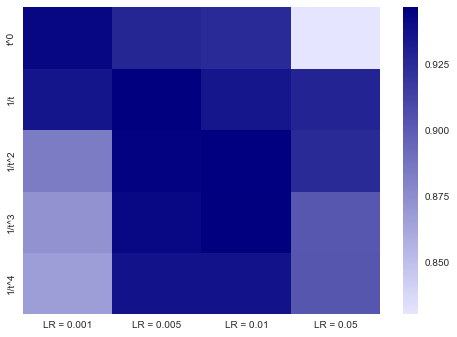

In [10]:
d = {'LR = 0.05': S_1,
     'LR = 0.01': S_10,
     'LR = 0.005': S_100,
     'LR = 0.001': S_1000}
data_frame = pd.DataFrame(d) 
blu = sns.light_palette("navy", as_cmap= True)
sns.heatmap(data_frame, cmap= blu)

In [ ]:
train_lstm_lr_100_aucs_mean = np.mean(train_lstm_lr_100_aucs, axis=0)
test_lstm_lr_100_aucs_mean = np.mean(test_lstm_lr_100_aucs, axis=0)

In [3]:
folds = 3
batch_size_nn = 16
batch_size_lstm = 16
hidden = 50
dropout_probability = 0.25

n_epochs = 25
epoch = 0


#-----------------------

train_lstm_lr_10_0_aucs = np.zeros((folds,n_epochs))
test_lstm_lr_10_0_aucs = np.zeros((folds,n_epochs))

train_lstm_lr_10_1_aucs = np.zeros((folds,n_epochs))
test_lstm_lr_10_1_aucs = np.zeros((folds,n_epochs))

train_lstm_lr_10_2_aucs = np.zeros((folds,n_epochs))
test_lstm_lr_10_2_aucs = np.zeros((folds,n_epochs))



#---------------------------

train_lstm_lr_100_0_aucs = np.zeros((folds,n_epochs))
test_lstm_lr_100_0_aucs = np.zeros((folds,n_epochs))

train_lstm_lr_100_1_aucs = np.zeros((folds,n_epochs))
test_lstm_lr_100_1_aucs = np.zeros((folds,n_epochs))

train_lstm_lr_100_2_aucs = np.zeros((folds,n_epochs))
test_lstm_lr_100_2_aucs = np.zeros((folds,n_epochs))



for i, (train_idx, test_idx) in enumerate(KFold(len(df_h),folds, shuffle=True)):
 
    
    
    
 
    
    
    #-------------------------------------------------------------------------
    
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm_lr_10_0 = Model(input = sequence, output = output)
    adam_lr_10_0 = Adam(lr = 0.01)
    lstm_lr_10_0.compile(optimizer = adam_lr_10_0 , loss='mean_squared_error')
    
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm_lr_10_1 = Model(input = sequence, output = output)
    adam_lr_10_1 = Adam(lr = 0.01)
    lstm_lr_10_1.compile(optimizer = adam_lr_10_1 , loss='mean_squared_error')
    
    
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm_lr_10_2 = Model(input = sequence, output = output)
    adam_lr_10_2 = Adam(lr = 0.01)
    lstm_lr_10_2.compile(optimizer = adam_lr_10_2 , loss='mean_squared_error')
    
   
    
    #---------------------------------------------------------------------------------

    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm_lr_100_0 = Model(input = sequence, output = output)
    adam_lr_100_0 = Adam(lr = 0.005)
    lstm_lr_100_0.compile(optimizer = adam_lr_100_0 , loss='mean_squared_error')
    
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm_lr_100_1 = Model(input = sequence, output = output)
    adam_lr_100_1 = Adam(lr = 0.005)
    lstm_lr_100_1.compile(optimizer = adam_lr_100_1 , loss='mean_squared_error')
    
    
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm_lr_100_2 = Model(input = sequence, output = output)
    adam_lr_100_2 = Adam(lr = 0.005)
    lstm_lr_100_2.compile(optimizer = adam_lr_100_2 , loss='mean_squared_error')
    
   
    
   

    
    
    for epoch in range(n_epochs):
        
        

       
        

    
        #----------------------------------------

        
        
    
        adam_lr_10_0.lr.set_value(0.01)
        lstm_lr_10_0.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    

        train_lstm_lr_10_0_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm_lr_10_0.predict(X[train_idx]))
        test_lstm_lr_10_0_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm_lr_10_0.predict(X[test_idx]))
        
        train_lstm_lr_10_0_aucs[i][epoch]=train_lstm_lr_10_0_auc
        test_lstm_lr_10_0_aucs[i][epoch]=test_lstm_lr_10_0_auc
        print("LSTM LR = 0.01): ", train_lstm_lr_10_0_auc, test_lstm_lr_10_0_auc, epoch)
        print("current learning rate: ", adam_lr_10_0.lr.get_value() )   
        
        
        
        adam_lr_10_1.lr.set_value(0.01*(epoch+1)**(-1))
        lstm_lr_10_1.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    

        train_lstm_lr_10_1_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm_lr_10_1.predict(X[train_idx]))
        test_lstm_lr_10_1_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm_lr_10_1.predict(X[test_idx]))
        
        train_lstm_lr_10_1_aucs[i][epoch]=train_lstm_lr_10_1_auc
        test_lstm_lr_10_1_aucs[i][epoch]=test_lstm_lr_10_1_auc
        print("LSTM LR = 0.01*t^(-1): ", train_lstm_lr_10_1_auc, test_lstm_lr_10_1_auc, epoch)
        print("current learning rate: ", adam_lr_10_1.lr.get_value() )
        
        
        
        adam_lr_10_2.lr.set_value(0.01*(epoch+1)**(-2))
        lstm_lr_10_2.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    

        train_lstm_lr_10_2_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm_lr_10_2.predict(X[train_idx]))
        test_lstm_lr_10_2_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm_lr_10_2.predict(X[test_idx]))
        
        train_lstm_lr_10_2_aucs[i][epoch]=train_lstm_lr_10_2_auc
        test_lstm_lr_10_2_aucs[i][epoch]=test_lstm_lr_10_2_auc
        print("LSTM LR = 0.01*t^(-2): ", train_lstm_lr_10_2_auc, test_lstm_lr_10_2_auc, epoch)
        print("current learning rate: ", adam_lr_10_2.lr.get_value() )
        
        
        
        
 

        
        #-----------------------------------------------------------------
        
        
        adam_lr_100_0.lr.set_value(0.005)
        lstm_lr_100_0.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    

        train_lstm_lr_100_0_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm_lr_100_0.predict(X[train_idx]))
        test_lstm_lr_100_0_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm_lr_100_0.predict(X[test_idx]))
        
        train_lstm_lr_100_0_aucs[i][epoch]=train_lstm_lr_100_0_auc
        test_lstm_lr_100_0_aucs[i][epoch]=test_lstm_lr_100_0_auc
        print("LSTM LR = 0.005: ", train_lstm_lr_100_0_auc, test_lstm_lr_100_0_auc, epoch)
        print("current learning rate: ", adam_lr_100_0.lr.get_value() )
        
        adam_lr_100_1.lr.set_value(0.005*(epoch+1)**(-1))
        lstm_lr_100_1.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    

        train_lstm_lr_100_1_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm_lr_100_1.predict(X[train_idx]))
        test_lstm_lr_100_1_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm_lr_100_1.predict(X[test_idx]))
        
        train_lstm_lr_100_1_aucs[i][epoch]=train_lstm_lr_100_1_auc
        test_lstm_lr_100_1_aucs[i][epoch]=test_lstm_lr_100_1_auc
        print("LSTM LR = 0.005*t^{-1}: ", train_lstm_lr_100_1_auc, test_lstm_lr_100_1_auc, epoch)
        print("current learning rate: ", adam_lr_100_1.lr.get_value() )
        
        adam_lr_100_2.lr.set_value(0.005*(epoch+1)**(-2))
        lstm_lr_100_2.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    

        train_lstm_lr_100_2_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm_lr_100_2.predict(X[train_idx]))
        test_lstm_lr_100_2_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm_lr_100_2.predict(X[test_idx]))
        
        train_lstm_lr_100_2_aucs[i][epoch]=train_lstm_lr_100_2_auc
        test_lstm_lr_100_2_aucs[i][epoch]=test_lstm_lr_100_2_auc
        print("LSTM LR = 0.005*t^{-2}: ", train_lstm_lr_100_2_auc, test_lstm_lr_100_2_auc, epoch)
        print("current learning rate: ", adam_lr_100_2.lr.get_value() )
        
        
        
        #-------------------------------------------------------------------
        
        






Epoch 1/1
6376/6376 [==============================] - 9s - loss: 0.0435     
LSTM LR = 0.01):  0.940990814785 0.930967040099 0
current learning rate:  0.009999999776482582
Epoch 1/1
6376/6376 [==============================] - 13s - loss: 0.0438    
LSTM LR = 0.01*t^(-1):  0.937532948759 0.922154117588 0
current learning rate:  0.009999999776482582
Epoch 1/1
6376/6376 [==============================] - 11s - loss: 0.0432    
LSTM LR = 0.01*t^(-2):  0.929175861509 0.918217304062 0
current learning rate:  0.009999999776482582
Epoch 1/1
6376/6376 [==============================] - 13s - loss: 0.0463    
LSTM LR = 0.005:  0.939585056077 0.929127529356 0
current learning rate:  0.004999999888241291
Epoch 1/1
6376/6376 [==============================] - 12s - loss: 0.0465    
LSTM LR = 0.005*t^{-1}:  0.934451844333 0.929129129129 0
current learning rate:  0.004999999888241291
Epoch 1/1
6376/6376 [==============================] - 13s - loss: 0.0463    
LSTM LR = 0.005*t^{-2}:  0.93760447184

KeyboardInterrupt: 

In [7]:
S_10 = pd.Series([test_lstm_lr_10_0_aucs[0][24],
test_lstm_lr_10_1_aucs[0][24],
test_lstm_lr_10_2_aucs[0][24]], index = ['t^0','1/t','1/t^2'])

S_100 = pd.Series([test_lstm_lr_100_0_aucs[0][24],
test_lstm_lr_100_1_aucs[0][24],
test_lstm_lr_100_2_aucs[0][24]], index = ['t^0','1/t','1/t^2'])

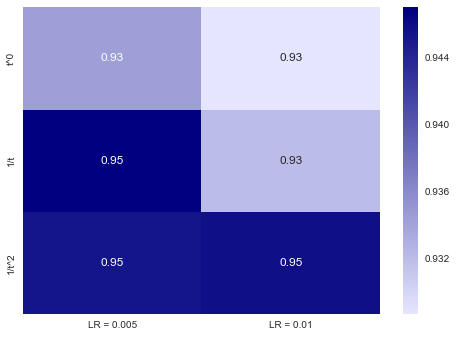

In [10]:
d = {
     'LR = 0.01': S_10,
     'LR = 0.005': S_100}

data_frame = pd.DataFrame(d) 
blu = sns.light_palette("navy", as_cmap= True)
sns.heatmap(data_frame, cmap= blu, annot = True)

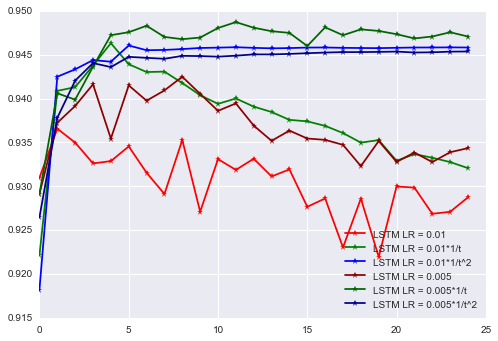

In [11]:
plt.plot(np.arange(0,25,1), test_lstm_lr_10_0_aucs[0,0:25], color= 'r', marker='*', linestyle='-', label ="LSTM LR = 0.01")
plt.plot(np.arange(0,25,1), test_lstm_lr_10_1_aucs[0,0:25], color= 'g', marker='*', linestyle='-', label ="LSTM LR = 0.01*1/t")
plt.plot(np.arange(0,25,1), test_lstm_lr_10_2_aucs[0,0:25], color= 'b', marker='*', linestyle='-', label ="LSTM LR = 0.01*1/t^2")
plt.plot(np.arange(0,25,1), test_lstm_lr_100_0_aucs[0,0:25], color= 'darkred', marker='*', linestyle='-', label ="LSTM LR = 0.005")
plt.plot(np.arange(0,25,1), test_lstm_lr_100_1_aucs[0,0:25], color= 'darkgreen', marker='*', linestyle='-', label ="LSTM LR = 0.005*1/t")
plt.plot(np.arange(0,25,1), test_lstm_lr_100_2_aucs[0,0:25], color= 'darkblue', marker='*', linestyle='-', label ="LSTM LR = 0.005*1/t^2")

plt.legend( loc=4)
plt.Figure(figsize=(100,100),dpi = 130)

In [3]:
folds = 3
batch_size_nn = 16
batch_size_lstm = 16
hidden = 50
dropout_probability = 0.25

n_epochs = 25
epoch = 0


#-----------------------

train_lstm_lr_10_0_aucs = np.zeros((folds,n_epochs))
test_lstm_lr_10_0_aucs = np.zeros((folds,n_epochs))

train_lstm_lr_10_1_aucs = np.zeros((folds,n_epochs))
test_lstm_lr_10_1_aucs = np.zeros((folds,n_epochs))

train_lstm_lr_10_2_aucs = np.zeros((folds,n_epochs))
test_lstm_lr_10_2_aucs = np.zeros((folds,n_epochs))



#---------------------------

train_lstm_lr_100_0_aucs = np.zeros((folds,n_epochs))
test_lstm_lr_100_0_aucs = np.zeros((folds,n_epochs))

train_lstm_lr_100_1_aucs = np.zeros((folds,n_epochs))
test_lstm_lr_100_1_aucs = np.zeros((folds,n_epochs))

train_lstm_lr_100_2_aucs = np.zeros((folds,n_epochs))
test_lstm_lr_100_2_aucs = np.zeros((folds,n_epochs))

#------------------------------

train_lstm_lr_1000_1_aucs = np.zeros((folds,n_epochs))
test_lstm_lr_1000_1_aucs = np.zeros((folds,n_epochs))


for i, (train_idx, test_idx) in enumerate(KFold(len(df_h),folds, shuffle=True)):
 
    
    
    
 
    
    
    #-------------------------------------------------------------------------
    
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm_lr_10_0 = Model(input = sequence, output = output)
    adam_lr_10_0 = Adam(lr = 0.01)
    lstm_lr_10_0.compile(optimizer = adam_lr_10_0 , loss='mean_squared_error')
    
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm_lr_10_1 = Model(input = sequence, output = output)
    adam_lr_10_1 = Adam(lr = 0.01)
    lstm_lr_10_1.compile(optimizer = adam_lr_10_1 , loss='mean_squared_error')
    
    
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm_lr_10_2 = Model(input = sequence, output = output)
    adam_lr_10_2 = Adam(lr = 0.01)
    lstm_lr_10_2.compile(optimizer = adam_lr_10_2 , loss='mean_squared_error')
    
   
    
    #---------------------------------------------------------------------------------

    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm_lr_100_0 = Model(input = sequence, output = output)
    adam_lr_100_0 = Adam(lr = 0.005)
    lstm_lr_100_0.compile(optimizer = adam_lr_100_0 , loss='mean_squared_error')
    
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm_lr_100_1 = Model(input = sequence, output = output)
    adam_lr_100_1 = Adam(lr = 0.005)
    lstm_lr_100_1.compile(optimizer = adam_lr_100_1 , loss='mean_squared_error')
    
    
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm_lr_100_2 = Model(input = sequence, output = output)
    adam_lr_100_2 = Adam(lr = 0.005)
    lstm_lr_100_2.compile(optimizer = adam_lr_100_2 , loss='mean_squared_error')
    
   
    # 
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm_lr_1000_1 = Model(input = sequence, output = output)
    adam_lr_1000_1 = Adam(lr = 0.001)
    lstm_lr_1000_1.compile(optimizer = adam_lr_1000_1 , loss='mean_squared_error')
    
   

    
    
    for epoch in range(n_epochs):
        
        

       
        

    
        #----------------------------------------

        
        
    
        adam_lr_10_0.lr.set_value(0.01*(0.95)**(epoch))
        lstm_lr_10_0.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    

        train_lstm_lr_10_0_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm_lr_10_0.predict(X[train_idx]))
        test_lstm_lr_10_0_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm_lr_10_0.predict(X[test_idx]))
        
        train_lstm_lr_10_0_aucs[i][epoch]=train_lstm_lr_10_0_auc
        test_lstm_lr_10_0_aucs[i][epoch]=test_lstm_lr_10_0_auc
        print("LSTM LR = 0.01): ", train_lstm_lr_10_0_auc, test_lstm_lr_10_0_auc, epoch)
        print("current learning rate: ", adam_lr_10_0.lr.get_value() )   
        
        
        
        adam_lr_10_1.lr.set_value(0.01*(epoch+1)**(-1.5))
        lstm_lr_10_1.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    

        train_lstm_lr_10_1_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm_lr_10_1.predict(X[train_idx]))
        test_lstm_lr_10_1_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm_lr_10_1.predict(X[test_idx]))
        
        train_lstm_lr_10_1_aucs[i][epoch]=train_lstm_lr_10_1_auc
        test_lstm_lr_10_1_aucs[i][epoch]=test_lstm_lr_10_1_auc
        print("LSTM LR = 0.01*t^(-1): ", train_lstm_lr_10_1_auc, test_lstm_lr_10_1_auc, epoch)
        print("current learning rate: ", adam_lr_10_1.lr.get_value() )
        
        
        
        adam_lr_10_2.lr.set_value(0.01*(epoch+1)**(-2))
        lstm_lr_10_2.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    

        train_lstm_lr_10_2_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm_lr_10_2.predict(X[train_idx]))
        test_lstm_lr_10_2_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm_lr_10_2.predict(X[test_idx]))
        
        train_lstm_lr_10_2_aucs[i][epoch]=train_lstm_lr_10_2_auc
        test_lstm_lr_10_2_aucs[i][epoch]=test_lstm_lr_10_2_auc
        print("LSTM LR = 0.01*t^(-2): ", train_lstm_lr_10_2_auc, test_lstm_lr_10_2_auc, epoch)
        print("current learning rate: ", adam_lr_10_2.lr.get_value() )
        
        
        
        
 

        
        #-----------------------------------------------------------------
        
        
        adam_lr_100_0.lr.set_value(0.005*(0.95)**(epoch))
        lstm_lr_100_0.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    

        train_lstm_lr_100_0_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm_lr_100_0.predict(X[train_idx]))
        test_lstm_lr_100_0_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm_lr_100_0.predict(X[test_idx]))
        
        train_lstm_lr_100_0_aucs[i][epoch]=train_lstm_lr_100_0_auc
        test_lstm_lr_100_0_aucs[i][epoch]=test_lstm_lr_100_0_auc
        print("LSTM LR = 0.005: ", train_lstm_lr_100_0_auc, test_lstm_lr_100_0_auc, epoch)
        print("current learning rate: ", adam_lr_100_0.lr.get_value() )
        
        adam_lr_100_1.lr.set_value(0.005*(epoch+1)**(-1.5))
        lstm_lr_100_1.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    

        train_lstm_lr_100_1_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm_lr_100_1.predict(X[train_idx]))
        test_lstm_lr_100_1_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm_lr_100_1.predict(X[test_idx]))
        
        train_lstm_lr_100_1_aucs[i][epoch]=train_lstm_lr_100_1_auc
        test_lstm_lr_100_1_aucs[i][epoch]=test_lstm_lr_100_1_auc
        print("LSTM LR = 0.005*t^{-1}: ", train_lstm_lr_100_1_auc, test_lstm_lr_100_1_auc, epoch)
        print("current learning rate: ", adam_lr_100_1.lr.get_value() )
        
        adam_lr_100_2.lr.set_value(0.005*(epoch+1)**(-2))
        lstm_lr_100_2.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    

        train_lstm_lr_100_2_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm_lr_100_2.predict(X[train_idx]))
        test_lstm_lr_100_2_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm_lr_100_2.predict(X[test_idx]))
        
        train_lstm_lr_100_2_aucs[i][epoch]=train_lstm_lr_100_2_auc
        test_lstm_lr_100_2_aucs[i][epoch]=test_lstm_lr_100_2_auc
        print("LSTM LR = 0.005*t^{-2}: ", train_lstm_lr_100_2_auc, test_lstm_lr_100_2_auc, epoch)
        print("current learning rate: ", adam_lr_100_2.lr.get_value() )
        
        
        
        #-------------------------------------------------------------------
        
        

        adam_lr_1000_1.lr.set_value(0.001*(1+epoch)**(-1))
        lstm_lr_1000_1.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    

        train_lstm_lr_1000_1_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm_lr_1000_1.predict(X[train_idx]))
        test_lstm_lr_1000_1_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm_lr_1000_1.predict(X[test_idx]))
        
        train_lstm_lr_1000_1_aucs[i][epoch]=train_lstm_lr_1000_1_auc
        test_lstm_lr_1000_1_aucs[i][epoch]=test_lstm_lr_1000_1_auc
        print("LSTM LR = 0.001*t^{-1}: ", train_lstm_lr_1000_1_auc, test_lstm_lr_1000_1_auc, epoch)
        print("current learning rate: ", adam_lr_1000_1.lr.get_value() )




Epoch 1/1
6376/6376 [==============================] - 12s - loss: 0.0434    
LSTM LR = 0.01):  0.935102273316 0.92817221455 0
current learning rate:  0.009999999776482582
Epoch 1/1
6376/6376 [==============================] - 9s - loss: 0.0428     
LSTM LR = 0.01*t^(-1):  0.937098841829 0.93118413258 0
current learning rate:  0.009999999776482582
Epoch 1/1
6376/6376 [==============================] - 9s - loss: 0.0442     
LSTM LR = 0.01*t^(-2):  0.935706683115 0.930836170745 0
current learning rate:  0.009999999776482582
Epoch 1/1
6376/6376 [==============================] - 11s - loss: 0.0458    
LSTM LR = 0.005:  0.932633121923 0.930094332318 0
current learning rate:  0.004999999888241291
Epoch 1/1
6376/6376 [==============================] - 8s - loss: 0.0471     
LSTM LR = 0.005*t^{-1}:  0.931101049431 0.925428132602 0
current learning rate:  0.004999999888241291
Epoch 1/1
6376/6376 [==============================] - 8s - loss: 0.0472     
LSTM LR = 0.005*t^{-2}:  0.935003569297 

KeyboardInterrupt: 

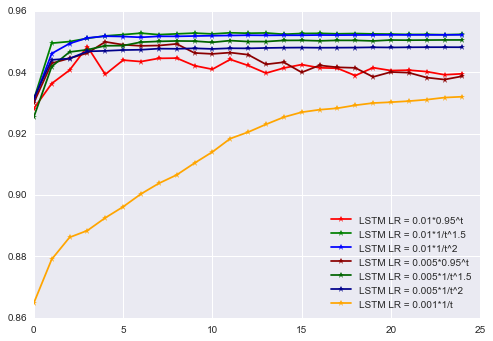

In [5]:
plt.plot(np.arange(0,25,1), test_lstm_lr_10_0_aucs[0,0:25], color= 'r', marker='*', linestyle='-', label ="LSTM LR = 0.01*0.95^t")
plt.plot(np.arange(0,25,1), test_lstm_lr_10_1_aucs[0,0:25], color= 'g', marker='*', linestyle='-', label ="LSTM LR = 0.01*1/t^1.5")
plt.plot(np.arange(0,25,1), test_lstm_lr_10_2_aucs[0,0:25], color= 'b', marker='*', linestyle='-', label ="LSTM LR = 0.01*1/t^2")
plt.plot(np.arange(0,25,1), test_lstm_lr_100_0_aucs[0,0:25], color= 'darkred', marker='*', linestyle='-', label ="LSTM LR = 0.005*0.95^t")
plt.plot(np.arange(0,25,1), test_lstm_lr_100_1_aucs[0,0:25], color= 'darkgreen', marker='*', linestyle='-', label ="LSTM LR = 0.005*1/t^1.5")
plt.plot(np.arange(0,25,1), test_lstm_lr_100_2_aucs[0,0:25], color= 'darkblue', marker='*', linestyle='-', label ="LSTM LR = 0.005*1/t^2")
plt.plot(np.arange(0,25,1), test_lstm_lr_1000_1_aucs[0,0:25], color= 'orange', marker='*', linestyle='-', label ="LSTM LR = 0.001*1/t")

plt.legend( loc=4)
plt.Figure(figsize=(100,100),dpi = 130)